In [1]:
import numpy as np
import numpy.linalg as lin
from scipy.integrate import ode
import matplotlib.pyplot as plt 
from matplotlib import animation
import numpy.random as ran
import time
import warnings
warnings.filterwarnings("ignore")
from matplotlib import rcParams
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.family': 'sans-serif',
         'text.usetex': True}
rcParams.update(params)
%matplotlib notebook

In [30]:
class disc_cont_model:
    
    # Defining variables of the scheme
    
    def __init__(self,L,N,dt,init_rho,init_agents,tmax):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L/N
        self.dy = L/N
        self.tmax = tmax
        self.chalf_x = np.linspace(-L,L,int(2*N+1))
        self.cspan_x = np.linspace(-L + self.dx/2, L - self.dx/2, int(2*N))
        self.chalf_y = np.linspace(-L,L,int(2*N+1))
        self.cspan_y = np.linspace(-L + self.dy/2, L - self.dy/2, int(2*N))
        self.X, self.Y = np.meshgrid(self.cspan_x,self.cspan_y)
        self.rho = [init_rho]
        self.agents = [init_agents]
        self.rho_ex = [np.concatenate([x for x in init_rho])]
        

        
        self.D = 6000 # mobility coefficient for leaders
        self.s = 2 # exponent of the potential near the origin
        self.Fr = 1 # strength of repulsion
        self.Rr = 20 # max. range of repulsive forces
        self.Ra = 60 # max. range of attractive forces
        self.Fa11 = 0.04 # strength of attraction between followers
        #self.Fa11 = 0.1
        #self.Fa11 = 0.015
        #self.Fa21 = 0.0038 # strength of attraction of leaders to followers
        self.Fa21 = .38
        self.Fa12 = 0.203 # strength of attraction of followers to leaders
        #self.Fa12 = 0.1503
        self.Fa22 = 0.00025 # strength of attraction between leaders
        
        self.Fstar = 32*self.s*(self.Ra-self.Rr)*(3*self.Ra**2+4*self.Rr*self.Ra + 3*self.Rr**2)/5/self.Rr**3/(11*self.s + 6)
        
        self.kint_dens = int(self.Ra/self.dx + .5) # range of interaction for convolutions. Given by Ra
        self.M = int(2*self.L/self.Ra-.5) # range of interaction for leaders. Given by Ra
        self.dbox = 2*self.L/self.M
        self.W_mat11 = 0 # convolution matrix for followers, to be updated later
    # This gives the exact box where each leader is (reduced interacion in leaders-leaders)
    
    def boxnum_agents(self,x):
        x1, x2 = x[0] + self.L, x[1] + self.L
        i = max([min([self.M - 1, int(x1/self.dbox)]),0])
        j = max([min([self.M - 1, int(x2/self.dbox)]),0])
        return i,j
    
    # This gives the indexes of the density matrix which are closest to a leader at x
    
    def boxnum_dens(self,x):
        x1, x2 = x[0] + self.L, x[1] + self.L
        i = max([min([2*self.N - 1, int(x1/self.dx)]),0])
        j = max([min([2*self.N - 1, int(x2/self.dx)]),0])
        return i,j
    
    # Definition of interaction potentials: H meaning \nabla W, and W is the radial potential
    # W_ij // 1: followers, 2: leaders
    
    def H21(self,x1,x2):
        x = np.array([x1,x2])
        h1 = -self.Fr*(self.Rr/2)**(3-2*self.s)*lin.norm(x)**(2*self.s-3)*(lin.norm(x) < self.Rr/2)
        h2 = (2*self.Fr*(lin.norm(x)-self.Rr)/self.Rr)*(lin.norm(x) < self.Rr)*(lin.norm(x) >= self.Rr/2)
        h3 = -4*self.Fa21*(lin.norm(x)-self.Rr)*(lin.norm(x)-self.Ra)/(self.Rr - self.Ra)**2*(lin.norm(x) < self.Ra)*(lin.norm(x) > self.Rr)
        return (h1 + h2 + h3)*x/lin.norm(x)
    
    def H22(self,x1,x2):
        x = np.array([x1,x2])
        h1 = -self.Fr*(self.Rr/2)**(3-2*self.s)*lin.norm(x)**(2*self.s-3)*(lin.norm(x) < self.Rr/2)
        h2 = (2*self.Fr*(lin.norm(x)-self.Rr)/self.Rr)*(lin.norm(x) < self.Rr)*(lin.norm(x) >= self.Rr/2)
        h3 = -4*self.Fa22*(lin.norm(x)-self.Rr)*(lin.norm(x)-self.Ra)/(self.Rr - self.Ra)**2*(lin.norm(x) < self.Ra)*(lin.norm(x) > self.Rr)
        return (h1 + h2 + h3)*x/lin.norm(x)
    
    def W11(self,x1,x2):
        #x = np.array([x1,x2])
        xnorm = np.sqrt(x1**2+x2**2)
        #C1 = self.Fr*self.Rr*self.s/4/(self.s - 1)-2/3*self.Fa11*(self.Ra-self.Rr)
        C2 = self.Fr*self.Rr - 2/3*self.Fa11*(self.Ra - self.Rr)
        C3 = 2*self.Fa11*self.Ra**2*(3*self.Rr-self.Ra)/3/(self.Ra-self.Rr)**2
        #h1 = (-self.Fr/2*(self.Rr/2)**(3-2*self.s)*xnorm**(2*self.s-2)/(self.s - 1) + C1)*(xnorm < self.Rr/2)
        #h2 = (self.Fr/self.Rr*xnorm**2 - 2*self.Fr*xnorm + C2)*(xnorm < self.Rr)*(xnorm >= self.Rr/2)
        h0 = (self.Fr/self.Rr*self.Rr**2 - 2*self.Fr*self.Rr + C2)*(xnorm < self.Rr)
        h3 = (-4*self.Fa11*(xnorm**3/3-xnorm**2/2*(self.Rr+self.Ra) + self.Ra*self.Rr*xnorm)/(self.Rr - self.Ra)**2 + C3)*(xnorm < self.Ra)*(xnorm >= self.Rr)
        #return (h1 + h2 + h3) #+h0
        return h3 + h0
    
    def W12(self,x1,x2):
        x = np.array([x1,x2])
        C1 = self.Fr*self.Rr*self.s/4/(self.s - 1)-2/3*self.Fa12*(self.Ra-self.Rr)
        C2 = self.Fr*self.Rr - 2/3*self.Fa12*(self.Ra - self.Rr)
        C3 = 2*self.Fa12*self.Ra**2*(3*self.Rr-self.Ra)/3/(self.Ra-self.Rr)**2
        h1 = (-self.Fr/2*(self.Rr/2)**(3-2*self.s)*lin.norm(x)**(2*self.s-2)/(self.s - 1) + C1)*(lin.norm(x) < self.Rr/2)
        h2 = (self.Fr/self.Rr*lin.norm(x)**2 - 2*self.Fr*lin.norm(x) + C2)*(lin.norm(x) < self.Rr)*(lin.norm(x) >= self.Rr/2)
        h3 = (-4*self.Fa12*(lin.norm(x)**3/3-lin.norm(x)**2/2*(self.Rr+self.Ra) + self.Ra*self.Rr*lin.norm(x))/(self.Rr - self.Ra)**2 + C3)*(lin.norm(x) < self.Ra)*(lin.norm(x) >= self.Rr)
        return (h1 + h2 + h3)
    
    # Auxiliary function to bring back the density matrix to its original shape
    
    def splitter(self,rho_expanded):
        return np.array(np.split(rho_expanded,2*self.N))
    
    # Entropy in the PDE
    
    def disc_entropy(self,f):
        return self.D*f +  np.array([[np.sum(np.multiply(w,f)) for w in ww] for ww in self.W_mat11])*self.dx*self.dy
    
    # Derivative of the entropy
    
    def velocities_x(self,h):
        return -(h[1:,:]-h[:-1,:])/self.dx
    
    def velocities_y(self,h):
        return -(h[:,1:]-h[:,:-1])/self.dy
    
    # Calculation of the fluxes using upwind
    
    def flux_x(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:-1,:]*np.maximum(v,zero_vec) + g[1:,:]*np.minimum(v,zero_vec)
        #F = (g[:-1,:] + g[1:,:])/2*v
        return np.concatenate([[np.zeros(len(F[0]))],F,[np.zeros(len(F[0]))]])
    
    def flux_y(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:,:-1]*np.maximum(v,zero_vec) + g[:,1:]*np.minimum(v,zero_vec)
        #F = (g[:,:-1] + g[:,1:])/2*v
        return np.transpose(np.concatenate([[np.zeros(len(F))],np.transpose(F),[np.zeros(len(F))]]))
    
    # drho/dt for the density of followers
    
    def grad_rho(self,t,p_expanded):
        p = self.splitter(p_expanded)
        h = self.disc_entropy(p)
        #plt.imshow(h,vmin = -.1,vmax = .1)
        #plt.colorbar()
        #plt.show()
        for x in self.agents[-2]: # agents at same time step -> -2!
            i1,j1 = self.boxnum_dens(x)
            imin, imax = max(i1 - self.kint_dens, 0), min(2*self.N - 1, i1 + self.kint_dens) + 1
            jmin, jmax = max(j1 - self.kint_dens, 0), min(2*self.N - 1, j1 + self.kint_dens) + 1
            h[jmin:jmax,imin:imax] += np.array([[self.W12(self.cspan_x[i] -  x[0], self.cspan_y[j] - x[1]) for i in range(imin,imax)] for j in range(jmin,jmax)])
        #plt.imshow(h, vmin = -.1,vmax = .1)
        #plt.colorbar()
        #plt.show()
        Fx = self.flux_x(self.velocities_x(h),p)
        Fy = self.flux_y(self.velocities_y(h),p)
        diff = -(Fx[1:,:]-Fx[:-1,:])/self.dx-(Fy[:,1:]-Fy[:,:-1])/self.dy 
        return np.concatenate([x for x in diff])
    
    # dXi/dt for the leaders
    
    def grad_agents(self):
        ag = self.agents[-1]
        new = []
        boxes = [[[] for i in range(self.M)] for j in range(self.M)]
        for k in range(len(ag)):
            i,j = self.boxnum_agents(ag[k])
            boxes[i][j].append(k)
        for k in range(len(ag)):
            x = ag[k]
            i1,j1 = self.boxnum_dens(x)
            imin, imax = max(i1 - self.kint_dens, 0), min(2*self.N - 1, i1 + self.kint_dens) + 1
            jmin, jmax = max(j1 - self.kint_dens, 0), min(2*self.N - 1, j1 + self.kint_dens) + 1
            rho_int = self.rho[-1][jmin:jmax,imin:imax]
            W_conv = np.array([[self.H21(self.cspan_x[i] - x[0],self.cspan_y[j] - x[1]) if i!=i1 or j!=j1 else [0,0] for i in range(imin,imax)] for j in range(jmin,jmax)]) # reduced interaction kernel
            #W_conv = np.array([[self.H21(self.cspan_x[i] - x[0],self.cspan_y[j] - x[1]) for i in range(imin,imax)] for j in range(jmin,jmax)]) # reduced interaction kernel
            dx = np.array([np.sum(np.multiply(W_conv[:,:,0],rho_int)),np.sum(np.multiply(W_conv[:,:,1],rho_int))])*self.dx**2*self.dt
            #print(dx)
            #print(np.sum(np.multiply(W_conv[:,:,0],rho_int)))
        # print(np.multiply(W_conv[:,:,0],rho_int))
            #plt.imshow(W_conv[:,:,1])
            #plt.colorbar()
            #plt.show()
            i1,j1 = self.boxnum_agents(x)
            ind = np.concatenate([boxes[i1 + i][j1 + j] for i in range(-1,2) for j in range(-1, 2) 
                                  if i1 + i >= 0 and i1 + i < self.M and j1 + j >= 0 and j1 + j < self.M])
            ind = np.array([int(j) for j in ind if ag[int(j)][0] != x[0] or ag[int(j)][1] != x[1]])
            dx += np.sum([self.H22(ag[j][0] - x[0],ag[j][1] - x[1]) for j in ind], axis = 0)*self.dt
            #dx += np.array(x)/lin.norm(x)*.06*self.dt
            #dx += np.array([1,0])*.12*self.dt
            #dx  = dx*0
            
            #plt.imshow(W_conv[:,:,0],vmin = -1,vmax = 1)
            #plt.colorbar()
            #plt.show()
            if x[0] + dx[0] > self.L:
                dx[0] = - dx[0] + self.L - x[0]
            elif x[0] + dx[0] < - self.L:
                dx[0] = - dx[0] + x[0] - self.L
            if x[1] + dx[1] > self.L:
                dx[1] = - dx[1] + self.L - x[1]
            elif x[1] + dx[1] < - self.L:
                dx[1] = - dx[1] + x[1] - self.L
            new.append(x + dx)
        self.agents.append(new)  
    
    # system solver
    
    def solve(self):
        self.W_mat11 = np.array([[self.W11(x-self.X,y-self.Y) for x in self.cspan_x] for y in self.cspan_y]) # updating W_mat11
        print(np.max(self.W_mat11))
        solODE = ode(self.grad_rho).set_integrator('dopri5')
        solODE.set_initial_value(self.rho_ex[0],0)
        t = 0
        while t < self.tmax:
            print('t = %.2f'% t,end = '\r')
            t += self.dt
            self.grad_agents()
            self.rho.append(self.splitter(solODE.integrate(t)))
        return np.array(self.rho), np.array(self.agents)

In [24]:
print(solver.Fstar, solver.Fr/solver.Fa11, solver.Fr/solver.Fa21, solver.Fr/solver.Fa12, solver.Fr/solver.Fa22)

38.4 250.0 2.5 49.26108374384236 40000.0


In [31]:
L = 400
N = 30
dx = L/N
dy = dx
dt = 1
tmax = 25
xspan = np.linspace(-L + dx/2, L - dx/2, int(2*N))
yspan = np.linspace(-L + dy/2, L - dy/2, int(2*N))
#init_rho = np.array([[100/np.pi/100**2 if abs(x + L - 100) < 100 and abs(y) < 100 else 0 for x in xspan] for y in yspan])
init_rho = np.array([[100/np.pi/100**2 if x**2 + y**2 < 100**2 else 0 for x in xspan] for y in yspan])
#init_agents = [[-L + 215,0], [-L + 215,-15], [-L + 215,15],[-L + 215,30],[-L + 215,-30],[-L + 215,45],[-L + 215,-45],[-L + 215,60],[-L + 215,-60],[-L + 215,-75],[-L + 215,75]]
#init_agents = [[100,0],[-100,0],[0,100],[0,-100],[100/np.sqrt(2),100/np.sqrt(2)],[100/np.sqrt(2),-100/np.sqrt(2)]]
init_agents = [[100,0],[-100,0],[0,100],[0,-100]]
init_agents = [[-100,0]]


solver = disc_cont_model(L,N,dt,init_rho,init_agents,tmax)
#solver = disc_cont_model(L,N,dt,rho[-1],agents[-1],tmax)
rho_sol, agents_sol = solver.solve()

-0.0


KeyboardInterrupt: 

In [445]:
np.save('rhosolhybrid.npy',rho_sol)
np.save('agentshybrid.npy',agents)

In [ ]:
#agents_sol = np.load('rhosolhybrid.npy')
#rho_sol = np.load('agentshybrid.npy')

<IPython.core.display.Javascript object>


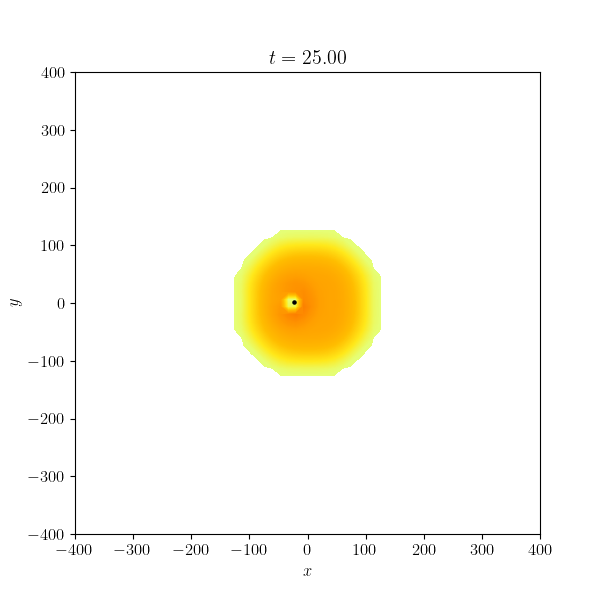

In [29]:
krem = 1
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%krem == 0]
agents = [agents_sol[i] for i in range(len(agents_sol)) if i%krem == 0]
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
ax.set_xlim(-L,L)
ax.set_ylim(-L,L)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
fig.canvas.draw()
ncont = 200
X,Y = solver.X, solver.Y
tspan = np.linspace(0,tmax,len(rho))
cmaplot = plt.cm.get_cmap("Wistia")
rhomin = 1e-18*0
cmaplot.set_under("white")
#sc = ax.contourf(X,Y,rho[0],ncont,cmap = 'Reds',vmin = 1e-4,vmax = np.max(rho))
#cb = fig.colorbar(sc,ax = ax)
#cb.set_label('$\\rho$',rotation = 0,labelpad = 15)
for i in range(len(rho)):
    
    ax.contourf(X,Y,rho[i],ncont,cmap = cmaplot,vmin = rhomin,vmax = np.max(rho),extend='min')
    ax.set_title('$t = %.2f$' % tspan[i])
    for y in agents[i]:
        ax.scatter(y[0],y[1], color = 'black', s = 5)
    fig.canvas.draw()
    if i == 0:
        time.sleep(2)
    del ax.collections[:]
    del ax.lines[:]
ax.contourf(X,Y,rho[-1],ncont,cmap = cmaplot,vmin = rhomin,vmax = np.max(rho),extend='min')
for y in agents[i]:
    ax.scatter(y[0],y[1], color = 'black', s = 5)
plt.show()

In [ ]:
np.min(rho)

In [75]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof


<IPython.core.display.Javascript object>


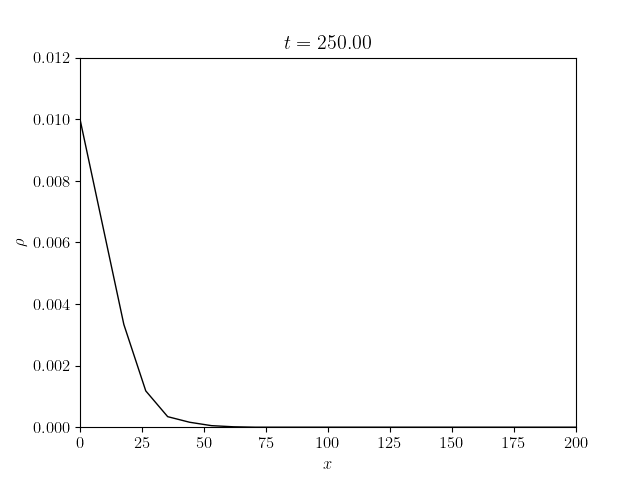

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111)
rad = [azimuthalAverage(r) for r in rho_sol]
rad = [rad[i] for i in range(len(rad)) if i%10 == 0]
rspan = np.linspace(0,L/np.sqrt(2),len(rad[0]))
#ax.set_xlim(0,L)
ax.set_ylabel('$\\rho$')
ax.set_xlabel('$x$')
plt.xlim(0,200)
ax.set_ylim(0,1.2*np.max(rad))
plt.ion()
fig.show()
fig.canvas.draw()
tspan = np.linspace(0,tmax,len(rad))
for i in range(len(rad)):
    ax.plot(rspan,rad[i],color = 'black',linewidth = 1)
    #ax.plot(np.linspace(-np.sqrt(2),np.sqrt(2),1000),1/np.pi*np.sqrt(2-np.linspace(-np.sqrt(2),np.sqrt(2),1000)**2),color = 'dodgerblue')
    ax.set_title('$t = %.2f$' % tspan[i])
    fig.canvas.draw()
    if i == 0:
        time.sleep(1)
    del ax.lines[:]
#ax.plot(solver.cspan,1/np.pi*np.sqrt(2-solver.cspan**2),color = 'dodgerblue')
ax.plot(rspan,rad[-1],'black',linewidth = 1)
plt.show()

In [66]:
len(rad)

1001

In [75]:
rspan = np.linspace(0,L/np.sqrt(2),len(rad))

In [78]:
len(rad)

1001